In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import transforms
from PIL import Image

In [2]:
# 設定圖像轉換 (包括 resize) - 前處理
transform = transforms.Compose([
    transforms.Resize((224, 224)),            # 調整大小
    transforms.RandomHorizontalFlip(p=0.5),        # 隨機水平翻轉
    transforms.RandomRotation(45),            # 隨機旋轉45度
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2), # 隨機改變亮度、對比度、飽和度和色調
    transforms.ToTensor(),                    # 轉換為 Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 標準化
])
trainval_transform = transforms.Compose([
    transforms.Resize((224, 224)),            # 調整大小
    transforms.ToTensor(),                    # 轉換為 Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 標準化
])

# 加載 Flowers102 資料集
train_dataset = Flowers102(root='./data', split='train', download=True, transform=trainval_transform)
test_dataset = Flowers102(root='./data', split='test', download=True, transform=transform)
val_dataset = Flowers102(root='./data', split='val', download=True, transform=trainval_transform)

# 查看資料集大小
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")
print(f"valing dataset size:{len(val_dataset)}")

#因為test_dataset遠大於train_dataset，因此要對調
# 加載 Flowers102 資料集
train_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

Training dataset size: 1020
Testing dataset size: 6149
valing dataset size:1020


Using GPU or other accelerator to Training.

In [3]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 3090 Ti , device num:0


左邊是BasicBlock,右邊是Bottleneck_Block

[64,64,256]表示out_chanl大小

![My Image](res_block.png)

In [4]:
#創建Bottleneck結構的block塊
class Res_Bottleneck_Block(nn.Module):
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Res_Bottleneck_Block, self).__init__()
        #1x1 convolution layer:改變通道數為 out_channel
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU(inplace=True)
        #3x3 卷積層，保持空間維度，使用 padding=1
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        #self.relu = nn.ReLU()
        # 1x1 卷積層，增大通道數到 out_channel * self.expansion
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel * self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel * self.expansion)
        #self.relu = nn.ReLU()

        self.downsample = downsample
    def forward(self, x):
        # 是否需要下采样来保证res与result可以正常相加
        if self.downsample is not None:
            x_origin = self.downsample(x)
        else:
          x_origin = x

        # print(f"0x資料形狀: {x.shape}")
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # print(f"conv1x資料形狀: {x.shape}")
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        # print(f"conv2x資料形狀: {x.shape}")
        x = self.conv3(x)
        x = self.bn3(x)
        # print(f"conv3x資料形狀: {x.shape}")

        #殘差相加
        # print(f"x_origin資料形狀: {x_origin.shape}")
        # print(f"x資料形狀: {x.shape}")
        out = x_origin + x

        out = self.relu(out)

        return x


In [5]:
class Res_BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(Res_BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


In [6]:
class ResNet(nn.Module):

    def __init__(self, block, blocks_num, num_classes=102, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_channel = 64
        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512 * block.expansion, 128 * block.expansion)
        self.dropout1 = nn.Dropout(dropout_rate)  # 第一層 Dropout
        self.fc2 = nn.Linear(128 * block.expansion, 64 * block.expansion)
        self.dropout2 = nn.Dropout(dropout_rate)  # 第二層 Dropout
        self.fc3 = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, out_channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != out_channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, out_channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel, out_channel, downsample=downsample, stride=stride))
        self.in_channel = out_channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, out_channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout1(x)  # 使用 Dropout
        x = self.fc1(x)
        # x = self.relu(x)
        # x = self.fc2(x)
        # x = self.dropout2(x)  # 使用 Dropout
        # x = self.relu(x)
        # x = self.fc3(x)

        return x

def resnet50(num_classes=102):
    return ResNet(Res_Bottleneck_Block, [3, 4, 6, 3], num_classes=num_classes)
def resnet34(num_classes=102):
    return ResNet(Res_BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

選擇要使用的神經網路

In [7]:
net = resnet34().to(device)

# 3. Define a Loss function and optimizer  
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^  
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=1e-4)
# you can try other optimizer like Adam, RMSprop, etc.

# 4. Train the network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^  
This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [9]:
EPOCHS = 300  # you can try more epochs number to get better performance.
train_losses = []
accuracy_arr = []
best_accuracy = 0.0  # 初始化最佳準確度
# ReduceLROnPlateau 根據驗證集的準確度下降學習率，當經過15個epoch，準確度都沒上升，學習率x0.1
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS) #使用 Cosine Annealing 作為學習率下降策略

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    net.train()  # 開始訓練模式
    loss_mean = 0
    # 訓練循環
    train_correct = 0
    train_total = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs, and use .to(device) to move your data to accelerator.
        inputs, labels = data[0].to(device), data[1].to(device)

        # Eliminate previous gradients to avoid gradients accumulation.
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i == 0:
            print(f"\nEpoch:{epoch + 1}")
        loss_mean += loss.item()
        print(f"\r\tBatch:{i + 1:03} of {len(train_loader)}, loss:{loss.item()}", end='')
    
    loss_mean = loss_mean / len(train_loader)
    print(f"\n\tloss_mean:{loss_mean}")
    train_losses.append(loss_mean)
    
    # 在每個訓練週期結束後計算驗證集的準確度
    net.eval()  # 切換到評估模式
    
    # 驗證循環 
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # 計算訓練集的準確度
    with torch.no_grad():
        for data in train_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

    # 計算準確度
    val_accuracy = val_correct / val_total if val_total > 0 else 0
    train_accuracy = train_correct / train_total if train_total > 0 else 0
    accuracy_arr.append(val_accuracy)
    
    print(f'\tValidation Accuracy after epoch {epoch + 1}: {val_accuracy:.2f}, {val_correct}/{val_total}')
    print(f'\tTraining Accuracy after epoch {epoch + 1}: {train_accuracy:.2f}, {train_correct}/{train_total}')

    # 檢查準確度是否是最佳的
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model_path = './res34/best_model_epoch'+str(epoch) +'.pth' # 權重檔的儲存路徑
        torch.save(net.state_dict(), best_model_path)  # 儲存最佳權重
        print(f'\tBest model saved with accuracy: {best_accuracy:.2f}')

    # 調整學習率
    scheduler.step()

print('\nFinished Training')



Epoch:1
	Batch:140 of 193, loss:4.1511616706848145

KeyboardInterrupt: 

# 5. Test the network on the test data  
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^  

We have trained the network for 10 passes over the training dataset.  
But we need to check if the network has learnt anything at all.  

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.  

Okay, first step. Let us display an image from the test set to get familiar.



The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100*correct/total}%, {correct} / {total}')

Accuracy of the network on the 10000 test images: 51 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
preds = np.zeros((1))
truth = np.zeros((1))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.numpy()], axis=0)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 71 %
Accuracy of   car : 66 %
Accuracy of  bird : 22 %
Accuracy of   cat : 30 %
Accuracy of  deer : 38 %
Accuracy of   dog : 50 %
Accuracy of  frog : 55 %
Accuracy of horse : 70 %
Accuracy of  ship : 48 %
Accuracy of truck : 52 %


Display the confusion matrix as a heatmap

Text(83.22222222222221, 0.5, 'label (ground truth)')

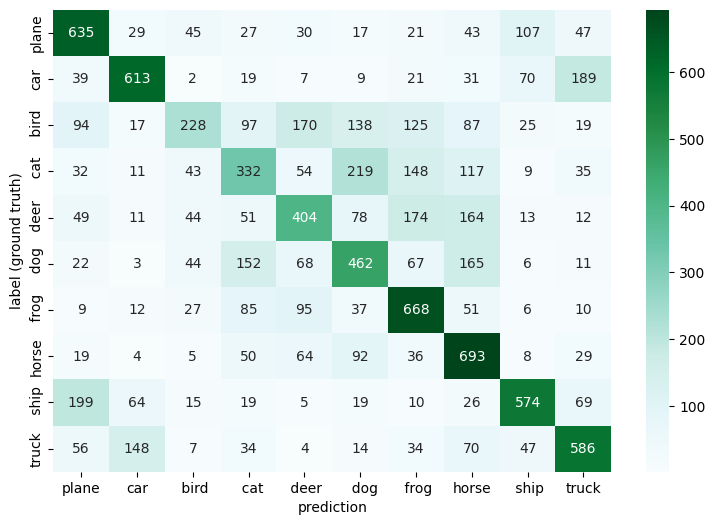

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
class_names = ['plane', 'car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")

Some multi-class performance report defined from Scikit-learn

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(truth, preds, target_names=class_names))

              precision    recall  f1-score   support

       plane       0.55      0.63      0.59      1001
         car       0.67      0.61      0.64      1000
        bird       0.50      0.23      0.31      1000
         cat       0.38      0.33      0.36      1000
        deer       0.45      0.40      0.43      1000
         dog       0.43      0.46      0.44      1000
        frog       0.51      0.67      0.58      1000
       horse       0.48      0.69      0.57      1000
        ship       0.66      0.57      0.62      1000
       truck       0.58      0.59      0.58      1000

    accuracy                           0.52     10001
   macro avg       0.52      0.52      0.51     10001
weighted avg       0.52      0.52      0.51     10001

